# Train RNN_RNN

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from utils.GloveMgr import GloveMgr
from utils.Dataset import Dataset
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

#from models.RNN_RNN import RNN_RNN

from time import time

import json
import argparse

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [4]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=32)
parser.add_argument('-epochs',type=int,default=1)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [5]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.100"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
model_name = "RNN_RNN"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 1
batch_size 32


## PyTorch initialisation

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1650


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Functions

In [8]:
def average(l):
    return sum(l) / len(l)

## Chargement des données

In [9]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.100d.txt", vocab_size=vocab_size)

In [10]:
train_dataset = Dataset(preprocess_df(pd.read_json("./data/train.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [11]:
val_dataset = Dataset(preprocess_df(pd.read_json("./data/val.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Model

In [12]:
from models.BasicModel import BasicModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class RNN_RNN(BasicModel):
    def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 100):
        super(RNN_RNN, self).__init__(device)

        self.device = device

        self.word_embedding = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)
        # Load word embedding if specified
        if word_embed is not None:
            self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

        # 100 : word2vec embedding size
        self.word_GRU = nn.GRU(input_size = dim_word_embed, hidden_size = 200, batch_first = True, bidirectional = True)
        self.sent_GRU = nn.GRU(input_size = 2*200, hidden_size=200, batch_first = True, bidirectional = True)

        # 10: relative position range size, with segment size = 10
        self.rel_pos_emb = nn.Embedding(11, 100)
        self.abs_pos_emb = nn.Embedding(100, 100)

        self.Wdoc = nn.Linear(2*200,2*200,bias=True)

        self.Wcontent = nn.Linear(2*200,1,bias=False)
        self.Wsalience = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wnovelty = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wabs_pos = nn.Linear(100,1,bias=False)
        self.Wrel_pos = nn.Linear(100,1,bias=False)
        self.bias = nn.Parameter(torch.empty(1).uniform_(-0.1, 0.1))

    def avg_pool1d(self,x,seq_lens):
        out = []
        for index,t in enumerate(x):
            if seq_lens[index] == 0:
                t = t[:1]
            else:
                t = t[:seq_lens[index],:]
            t = torch.t(t).unsqueeze(0)
            out.append(F.avg_pool1d(t,t.size(2)))
        
        out = torch.cat(out).squeeze(2)
        return out

    def forward(self, arr_x, doc_lens):
        probs = []

        max_doc_lens = max(doc_lens)
        sent_lens = torch.sum(torch.sign(arr_x),dim=1).data

        arr_x = self.word_embedding(arr_x)
        arr_x = self.word_GRU(arr_x)[0]
        arr_x = self.avg_pool1d(arr_x, sent_lens)

        arr_x = self.pad_doc(arr_x, doc_lens)

        arr_x = self.sent_GRU(arr_x)[0]
        sents_all_docs = arr_x.reshape(len(doc_lens) * max_doc_lens, 2*200) # flat docs
        
        docs = self.avg_pool1d(arr_x, doc_lens)
        docs = torch.tanh(self.Wdoc(docs))
        docs_for_each_sent = docs.repeat_interleave(max_doc_lens, dim=0) # repeat doc n times
        
        contents = self.Wcontent(sents_all_docs)
        saliences = self.Wsalience(sents_all_docs, docs_for_each_sent)

        # Compute position embedding
        abs_poses = torch.tensor([[position] for i in range(len(doc_lens)) for position in range(max_doc_lens)], dtype=torch.long)
        abs_poses = abs_poses.to(self.device)
        abs_poses = self.abs_pos_emb(abs_poses).squeeze(1)
        aps = self.Wabs_pos(abs_poses)

        # Compute relative position embedding
        rel_poses = torch.tensor([[int(round(position / 10))] for i in range(len(doc_lens)) for position in range(max_doc_lens)], dtype=torch.long)
        rel_poses = rel_poses.to(self.device)
        rel_poses = self.rel_pos_emb(rel_poses).squeeze(1)
        rps = self.Wrel_pos(rel_poses)

        # for each document, compute probabilities
        for idx, doc_len in enumerate(doc_lens):
            sents = arr_x[idx,:doc_len,:]
            s = torch.zeros(1,2*200)
            s = s.to(self.device)
            #prob_doc = []
            for position, h in enumerate(sents):
                h = h.view(1, -1) # resize

                # Compute proba
                content = contents[idx * max_doc_lens + position]
                salience = saliences[idx * max_doc_lens + position]
                novelty = -1 * self.Wnovelty(h,torch.tanh(s))
                ap = aps[idx * max_doc_lens + position]
                rp = rps[idx * max_doc_lens + position]
                if idx == 1 and position == 3:
                    print(rp[0])
                    print(rps[idx * max_doc_lens + position])
                    while True:
                        None
                prob = torch.sigmoid(content+salience+novelty+ap+rp+self.bias)

                #prob_doc.append(prob)
                probs.append(prob)

                s = s + torch.mm(prob,h)

            #probs.append(torch.tensor(prob_doc))

        probs = torch.cat(probs).squeeze()
        #probs = probs.to(self.device)
        return probs

In [13]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [14]:
model.to(device)

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

mae_fn = nn.L1Loss()

## Train

In [16]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [17]:
arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["doc"]))
                features = features + batch[j]["doc"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            targets = torch.cat(targets)
            targets = targets.to(device)
            
            probs = model(features, doc_lens)
            
            loss = loss_fn(probs, targets)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            nb_batch_train += 1
            total_train_loss += loss.item()
            total_train_mae += mae_fn(probs, targets).item()
            total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)
    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")
    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0
    for i,batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(batch_size):
            doc_lens.append(len(batch[j]["doc"]))
            features = features + batch[j]["doc"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
        targets = torch.cat(targets)
        targets = targets.to(device)
        
        probs = model(features, doc_lens)
        loss = loss_fn(probs, targets)
        nb_batch_val += 1
        total_val_loss += loss.item()
        total_val_mae += mae_fn(probs, targets).item()
        total_val_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
    print("Epoch {} : train loss = {:.3f}, val loss = {:.3f}, train mae = {:.3f}, val mae = {:.3f}, train accuracy = {:.3f}, val accuracy = {:.3f}".format(epoch, total_train_loss / nb_batch_train, total_val_loss / nb_batch_val, total_train_mae / nb_batch_train, total_val_mae / nb_batch_val, total_train_acc / nb_batch_train, total_val_acc / nb_batch_val))

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_mae.append(total_train_mae / nb_batch_train)
    arr_train_acc.append(total_train_acc / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_mae.append(total_val_mae / nb_batch_val)
    arr_val_acc.append(total_val_acc / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1:   0%|          | 0/32 [00:00<?, ?batch/s]

tensor([0.1177], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.1177], device='cuda:0', grad_fn=<SelectBackward0>)


Epoch 1:   0%|          | 0/32 [00:06<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

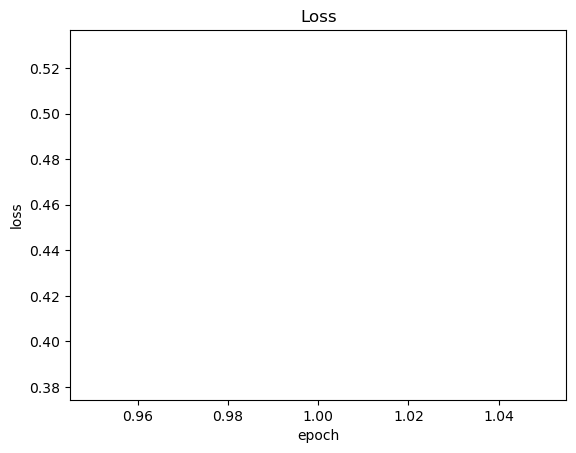

In [ ]:
# draw Losses
if is_graphic:
    plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss)
    plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss)

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.show()

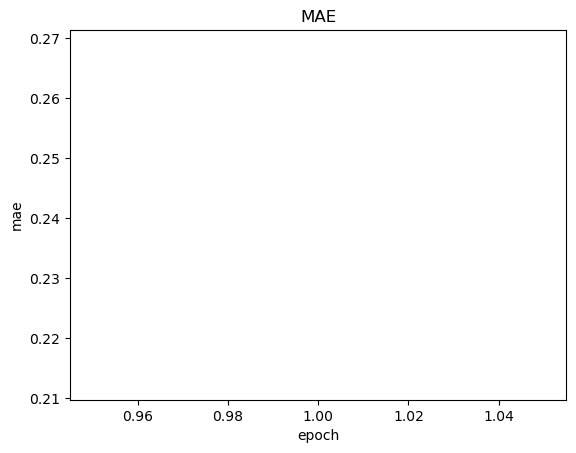

In [ ]:
# draw mae
if is_graphic:
    plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae)
    plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae)

    plt.title("MAE")
    plt.xlabel("epoch")
    plt.ylabel("mae")

    plt.show()

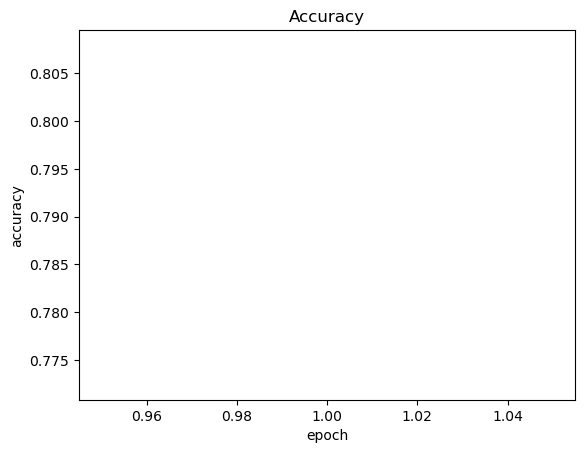

In [ ]:
# draw Accuracies
if is_graphic:
    plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc)
    plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc)

    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

    plt.show()

# Eval model

In [ ]:
from utils.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils.threshold_probs import threshold_probs_by_prop

In [ ]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [ ]:
best_epoch = np.argmax(np.array(arr_val_acc)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [ ]:
test_set = pd.read_json("./data/test.json")
test_set["doc_splited"] = split_all_docs(test_set["text"])

In [ ]:
test_dataset = Dataset(preprocess_df(pd.read_json("./data/test.json"), glovemgr=glovemgr, is_sep_n=True, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

KeyboardInterrupt: 

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
mae_fn = nn.L1Loss()

In [ ]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_iter, unit="batch", total=len(test_iter)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Eval model")
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["doc"]))
            features = features + batch[j]["doc"]
                
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        targets = torch.cat(targets)
        targets = targets.to(device)

        probs = model(features, doc_lens)

        doc = test_set["doc_splited"][idx]
        if len(doc) > 1 and len(doc) == probs.shape[0] and probs.shape[0] == targets.shape[0]:
            probs = torch.tensor(threshold_probs_by_prop(probs=probs.cpu().detach().numpy(), doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document+0.1), dtype=torch.float).to(device)
            txt = ""
            
            # print(len(doc), " ==", probs.shape)
            for i in range(len(doc)):
                if probs[i] == 1:
                    txt = txt + doc[i] + "."

            scores = scorer.score(txt, test_set["summaries"][idx])
            arr_rouge1.append(scores["rouge1"].fmeasure)
            arr_rouge2.append(scores["rouge2"].fmeasure)
            arr_rougeL.append(scores["rougeL"].fmeasure)

            mae.append(mae_fn(probs, targets).item())

            accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens))
            idx += 1
            tepoch.set_postfix(accuracy = average(accuracy), mae = average(mae), rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

Eval model: 100%|██████████| 10350/10350 [05:22<00:00, 32.14batch/s, accuracy=0.794, mae=0.263, rouge1=0.285, rouge2=0.146, rougeL=0.193]


In [ ]:
test_metrics = {}
test_metrics["accuracy"] = average(accuracy)
test_metrics["mae"]      = average(mae)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)